# Data Preprocessing

Earlier, I examined the data presented to me, drew some conclusions and made some assumptions about some of the necessary features to train the model. Now, the result of this work should be a dataset of features and a dependent variable, on the basis of which I will train the model

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
events_data = pd.read_csv(r"event_data_train.csv")
submission_data = pd.read_csv(r"submissions_data_train.csv")

# STEP 1. Obtain the target variable

1.1 To get the target variable, I need to check how many unique corrects each student has during the whole course, and if it is more than 40 - such student will be considered successful by stepic conditions. To do this, first let's see how many corrects each student has:

In [2]:
users_data_1 = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_data_1.describe()

action,user_id,discovered,passed,started_attempt,viewed
count,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000
mean,13363.573672,35.847718,33.811532,16.119736,95.187169
std,7750.057260,56.576201,54.932368,31.249011,346.323327
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6636.500000,1.000000,1.000000,0.000000,1.000000
50%,13358.000000,9.000000,8.000000,2.000000,12.000000
75%,20073.750000,42.000000,39.000000,15.000000,89.000000
max,26798.000000,198.000000,198.000000,721.000000,32778.000000


It's interesting to look at the .describe() on our first fics. We have 19234 users, and on average each user turned in 34 assignments, yet 75% quartile of all students turned in only 39 assignments, and max 198. This supports the thesis that a large portion of students don't complete the online course all the way through, which means the study definitely makes sense.

1.2 Same for the second dataset. Now we can see how many tasks each user has completed, and how many he/she has not conquered

In [3]:
users_corrects_1 = submission_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_corrects_1.describe()

submission_status,user_id,correct,wrong
count,9940.000000,9940.000000,9940.000000
mean,13312.917002,22.404930,28.812777
std,7795.938271,26.389536,52.868052
min,2.000000,0.000000,0.000000
25%,6523.500000,2.000000,1.000000
50%,13303.500000,9.000000,9.000000
75%,20101.750000,31.000000,36.000000
max,26798.000000,421.000000,1001.000000


The story is the same. First, I'll note that the number of unique users who attempted to complete the task is much smaller, only 9940. Earlier I wondered how it came about that the number of correct answers is roughly equal to the number of incorrect answers. This table confirms and explains it. Roughly speaking, there are active users who have a high value for wrong answers, but there are very few of them, and their number of wrong answers is sometimes very high. They increase the average wrong answer a lot. But more users have a very low number of incorrect answers. They were not actively using our resource. 

1.3 Let's merge the two tables. If some user is not in submission_data, then its values corr and wrong = 0

In [4]:
users_data_1 = users_data_1.merge(users_corrects_1,how='outer')
users_data_1 = users_data_1.fillna(0)
users_data_1

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,10,2.0,0.0
2,3,91,87,30,192,29.0,23.0
3,5,11,11,4,12,2.0,2.0
4,7,1,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0
19230,26793,1,0,1,1,0.0,0.0
19231,26794,69,69,34,180,33.0,9.0
19232,26797,10,10,2,13,2.0,0.0


1.4 Now let's determine which of correct were unique - for this purpose we simply remove duplicates in the case when stepp, student and correct match in the same place. We will leave only unique such matches:

In [5]:
submission_data.sort_values(by='user_id')
sub = submission_data[['step_id','submission_status','user_id']]
sub = sub.loc[sub.submission_status == 'correct']
sub = sub.drop_duplicates()
sub = sub.groupby('user_id').agg({'submission_status':'count'}).rename(columns={'step_id':'uniq_correct'})
sub = sub.reset_index()
sub

,user_id,submission_status
0,2,2
1,3,29
2,5,2
3,8,9
4,16,76
...,...,...
9789,26787,3
9790,26790,1
9791,26794,29
9792,26797,2


Now let's add these unique responses to the common table. It will assume that if there are no unique answers, it is 0:

In [6]:
users_data_1 = users_data_1.merge(sub,how='outer')
users_data_1 = users_data_1.fillna(0)
users_data_1 = users_data_1.rename(columns={'submission_status':'unique_correct'})
users_data_1

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,unique_correct
0,1,1,0,0,1,0.0,0.0,0.0
1,2,9,9,2,10,2.0,0.0,2.0
2,3,91,87,30,192,29.0,23.0,29.0
3,5,11,11,4,12,2.0,2.0,2.0
4,7,1,1,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0,1.0
19230,26793,1,0,1,1,0.0,0.0,0.0
19231,26794,69,69,34,180,33.0,9.0,29.0
19232,26797,10,10,2,13,2.0,0.0,2.0


Now I want to create a nominative dependent variable: "did the person pass 40 tasks?" I do it as follows: 

In [7]:
users_data_1['is_passed_course'] = users_data_1.unique_correct > 40
users_data_1

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,unique_correct,is_passed_course
0,1,1,0,0,1,0.0,0.0,0.0,False
1,2,9,9,2,10,2.0,0.0,2.0,False
2,3,91,87,30,192,29.0,23.0,29.0,False
3,5,11,11,4,12,2.0,2.0,2.0,False
4,7,1,1,0,1,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0,1.0,False
19230,26793,1,0,1,1,0.0,0.0,0.0,False
19231,26794,69,69,34,180,33.0,9.0,29.0,False
19232,26797,10,10,2,13,2.0,0.0,2.0,False


This will be the target variable. Let's look at the distribution:

In [8]:
users_data_1.is_passed_course.describe()

count     19234
unique        2
top       False
freq      17310
Name: is_passed_course, dtype: object

I will calculate what percentage of all students completed the 40 practice tasks:

In [9]:
((19234 - 17310) / 19234) * 100

10.003119475928044

In [10]:
passed_course = users_data_1[['user_id','is_passed_course']]
passed_course

,user_id,is_passed_course
0,1,False
1,2,False
2,3,False
3,5,False
4,7,False
...,...,...
19229,26790,False
19230,26793,False
19231,26794,False
19232,26797,False


In general, this can be considered an "appropriate" value for this parameter, it is higher than the industry average, but in this case we consider successful all students who passed at least 40 assignments. And there are 198 of them in the course.

# STEP 2. We save only those data that relate to the first two days of user activities

I will take the two days into account as follows: first, I will define the start date for each user to start using the course. Then I will add two days to this date, and after that I will delete all user steps that do not fit within this period. Let's go!

In [11]:
time_data = events_data.groupby('user_id',as_index=False) \
.agg({'timestamp' : 'min'}).rename(columns={'timestamp' : 'first_timestamp'})
time_data['last_date'] = time_data.first_timestamp + (60*60*24*2)
time_data

,user_id,first_timestamp,last_date
0,1,1472827464,1473000264
1,2,1514383364,1514556164
2,3,1434358476,1434531276
3,5,1466156809,1466329609
4,7,1521634660,1521807460
...,...,...,...
19229,26790,1451484016,1451656816
19230,26793,1510225031,1510397831
19231,26794,1495287049,1495459849
19232,26797,1508425316,1508598116


I have created a certain frame in which each user has the time of his first action, as well as the time of the first two days of using the resource.Then I want to connect this data with the original data and leave in the original frame only those lines whose timestamp will be less than or equal to the first two days.Everything will be connected clearly, because the connection will be made by user_id individually!

In [12]:
exp_data = events_data
exp_data = exp_data.merge(time_data,how = 'outer')
two_days_data = exp_data.loc[exp_data.last_date >= exp_data.timestamp]
events_two_days = two_days_data
events_two_days.shape

(906203, 6)

In [13]:
events_two_days.user_id.nunique()

19234

I have 906k records in the new frame.The original frame had almost 3.5 million, which fits the concept.I also made sure that I didn't lose a single user - all 19234 people are still there

Теперь нужно сделать тоже самое для фрейма submission, чтобы работать уже с этими сэтами:

In [14]:
sub_d = submission_data.groupby('user_id').agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'})
sub_d['2_days_timestamp'] = sub_d.min_timestamp + (60*60*24*2)
sub_d = sub_d.reset_index()
exp_sub = submission_data
exp_sub = exp_sub.merge(sub_d,how='outer')
exp_sub = exp_sub.loc[exp_sub['2_days_timestamp']>=exp_sub.timestamp]
submission_2_days = exp_sub
submission_2_days.shape

(134612, 6)

In [15]:
submission_2_days.user_id.nunique()

9940

Checking that I haven't lost any user - all 9940 unique users who tried to submit a practice paper are in place

# STEP 3. Feature engineering

I think it would be wise to first list the features needed to train the model:

Получаю первую фичу: число уникальных дней:

In [16]:
events_two_days['date'] = pd.to_datetime(events_two_days.timestamp, unit ='s')
events_two_days['day'] = events_two_days.date.dt.date
unique_days =  events_two_days.groupby('user_id').day.nunique()
unique_days = unique_days.to_frame().reset_index()
unique_days

C:\Users\HP\AppData\Local\Temp\ipykernel_112\3112120688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_two_days['date'] = pd.to_datetime(events_two_days.timestamp, unit ='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_112\3112120688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_two_days['day'] = events_two_days.date.dt.date


,user_id,day
0,1,1
1,2,1
2,3,1
3,5,1
4,7,1
...,...,...
19229,26790,1
19230,26793,1
19231,26794,2
19232,26797,1


I got a dataframe unique_days, which for each user has id and number of unique days. I got the first important feature!

Now I'll get to the already available chips, such as the number of correct, unique correct, and just correct answers:

In [17]:
users_data = events_two_days.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_corrects = submission_2_days.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_data = users_data.merge(users_corrects,how='outer')
users_data = users_data.fillna(0)
submission_2_days.sort_values(by='user_id')
sub = submission_2_days[['step_id','submission_status','user_id']]
sub = sub.loc[sub.submission_status == 'correct']
sub = sub.drop_duplicates()
sub = sub.groupby('user_id').agg({'submission_status':'count'}).rename(columns={'step_id':'uniq_correct'})
sub = sub.reset_index()
sub = sub.rename(columns={'submission_status':'unique_correct'})
users_data = users_data.merge(sub, how = 'outer')
users_data = users_data.merge(unique_days, how = 'outer')
users_data['correct_ratio'] = (users_data.unique_correct / (users_data.unique_correct + users_data.wrong)).round(2)
steps_tried = submission_2_days.groupby('user_id').step_id.nunique().to_frame().reset_index() \
.rename(columns={'day' : 'steps_tried'})
users_data = users_data.merge(steps_tried, how = 'outer')
users_data = users_data.merge(passed_course, how = 'outer')
users_data = users_data.rename(columns={'step_id':'steps_trying'})
users_data = users_data.set_index('user_id')
users_data = users_data.fillna(0)
users_data

,discovered,passed,started_attempt,viewed,correct,wrong,unique_correct,day,correct_ratio,steps_trying,is_passed_course
user_id,,,,,,,,,,,
1,1,0,0,1,0.0,0.0,0.0,1,0.00,0.0,False
2,9,9,2,9,2.0,0.0,2.0,1,1.00,2.0,False
3,15,15,4,20,4.0,4.0,4.0,1,0.50,4.0,False
5,1,1,0,1,2.0,2.0,2.0,1,0.50,2.0,False
7,1,1,0,1,0.0,0.0,0.0,1,0.00,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...
26790,2,2,0,2,1.0,0.0,1.0,1,1.00,1.0,False
26793,1,0,1,1,0.0,0.0,0.0,1,0.00,0.0,False
26794,50,50,24,90,24.0,7.0,22.0,2,0.76,22.0,False


I decided to add a couple more features. The first one is whether the student has passed the most difficult task that users face in the first two days of working with the site. The second feature will be the time from the first to the last user action on the site in hours. I'll start with the hardest task:

In [18]:
hard_step = submission_2_days.groupby(['step_id','submission_status']).agg({'timestamp':'count'}).reset_index()
hard_step = hard_step.rename(columns={'timestamp':'trying'})
hard_step = hard_step.loc[hard_step.submission_status == 'wrong']
hard_step.sort_values('trying')

,step_id,submission_status,trying
111,33674,wrong,5
115,33676,wrong,6
139,33983,wrong,6
125,33686,wrong,7
148,34041,wrong,7
...,...,...,...
57,32812,wrong,4033
7,31977,wrong,4498
23,32031,wrong,4823
3,31972,wrong,5485


I found the most problematic step: step_id = 31978. Now we need to figure out for each student if he/she passed this step

In [19]:
succses_students = submission_2_days.loc[submission_2_days.step_id == 31978 ]
succses_students = succses_students.drop(['timestamp',
                                          'min_timestamp','2_days_timestamp'],axis=1)
succses_students = succses_students.loc[succses_students.submission_status == 'correct']
succses_students = succses_students.drop_duplicates()
succses_students = succses_students.sort_values('user_id').reset_index()
succses_students = succses_students.drop('index',axis=1)
succses_students
succses_students['passed_hard_step'] = succses_students['submission_status'] == 'correct'
test = users_data
test = test.reset_index()
test = test.merge(succses_students,how='outer')
test = test[['user_id','passed_hard_step']]
test = test.fillna(False)
test = pd.get_dummies(test)
test['passed_hard_step'] = test['passed_hard_step'].replace({True: 1, False: 0})
test.passed_hard_step.describe()

count    19234.000000
mean         0.183477
std          0.387067
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: passed_hard_step, dtype: float64

I was able to create this feature for all users. Now I will take care of the time students spent on the course.

In [20]:
lst = pd.DataFrame()
lst['first_timestamp'] = events_two_days.groupby('user_id').agg({'timestamp':'min'})
lst['last_timestamp'] = events_two_days.groupby('user_id').agg({'timestamp':'max'})
lst['use_time'] = ((lst.last_timestamp - lst.first_timestamp) / (60*60)).round(2)
lst = lst['use_time']
lst = lst.to_frame().reset_index()
lst = lst.merge(test,how='outer')
users_data = users_data.reset_index()
users_data = users_data.merge(lst,how='outer')
users_data

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,unique_correct,day,correct_ratio,steps_trying,is_passed_course,use_time,passed_hard_step
0,1,1,0,0,1,0.0,0.0,0.0,1,0.00,0.0,False,0.00,0
1,2,9,9,2,9,2.0,0.0,2.0,1,1.00,2.0,False,0.05,0
2,3,15,15,4,20,4.0,4.0,4.0,1,0.50,4.0,False,0.31,0
3,5,1,1,0,1,2.0,2.0,2.0,1,0.50,2.0,False,0.00,0
4,7,1,1,0,1,0.0,0.0,0.0,1,0.00,0.0,False,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,2,2,0,2,1.0,0.0,1.0,1,1.00,1.0,False,0.01,0
19230,26793,1,0,1,1,0.0,0.0,0.0,1,0.00,0.0,False,0.00,0
19231,26794,50,50,24,90,24.0,7.0,22.0,2,0.76,22.0,False,30.29,1
19232,26797,10,10,2,10,2.0,0.0,2.0,1,1.00,2.0,False,0.20,0


# STEP 4. Preliminary analysis of features

The idea is as follows - I want to look at the average values of my features in the "passed the course" and "failed the course" dataframes and notice correlations there. Then I would like to build a correlation matrix for all the fiches. I'm sure there will be a lot of multicollinearity in my data

In [21]:
right = users_data.loc[users_data.is_passed_course == True]
fails = users_data.loc[users_data.is_passed_course == False]
right.passed_hard_step.describe()

count    1924.000000
mean        0.662162
std         0.473096
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: passed_hard_step, dtype: float64

In [22]:
fails.passed_hard_step.describe()

count    17310.000000
mean         0.130272
std          0.336612
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: passed_hard_step, dtype: float64

By .describe(), we see that the average values of our phytes in the network of "successful" students are an order of magnitude higher than their less successful counterparts. Hence, we can conclude that the chips are selected "quite well"

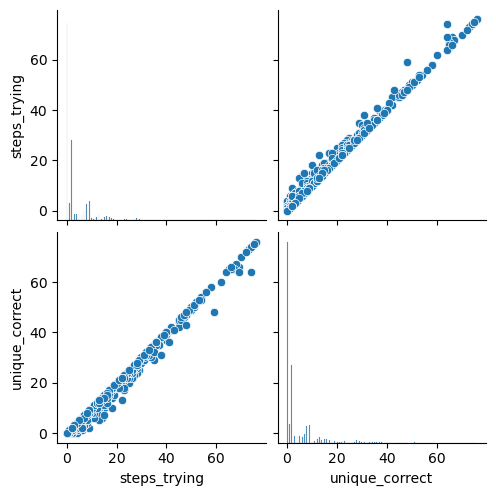

In [23]:
sns.pairplot(data=users_data[['steps_trying','unique_correct']])

MULTICOLLINEARITY !!! In the dataset you are looking for, I remove correct

In [24]:
users_data = users_data.drop('correct',axis=1)

You can speed up the process by using .corr()

In [26]:
users_data = users_data[['passed','viewed','wrong','unique_correct','correct_ratio','is_passed_course',
                        'use_time','passed_hard_step']]
users_data.corr()

,passed,viewed,wrong,unique_correct,correct_ratio,is_passed_course,use_time,passed_hard_step
passed,1.000000,0.886313,0.523463,0.830793,0.359062,0.403525,0.590147,0.663082
viewed,0.886313,1.000000,0.570593,0.718606,0.264745,0.344254,0.601074,0.586826
wrong,0.523463,0.570593,1.000000,0.618290,0.015794,0.264452,0.377930,0.495963
unique_correct,0.830793,0.718606,0.618290,1.000000,0.348923,0.482413,0.514609,0.775601
correct_ratio,0.359062,0.264745,0.015794,0.348923,1.000000,0.266057,0.276917,0.281648
is_passed_course,0.403525,0.344254,0.264452,0.482413,0.266057,1.000000,0.318574,0.412315
use_time,0.590147,0.601074,0.377930,0.514609,0.276917,0.318574,1.000000,0.511188
passed_hard_step,0.663082,0.586826,0.495963,0.775601,0.281648,0.412315,0.511188,1.000000


We keep the fiches correlated with the target variable, and only the number that help avoid multicollinearity.

In [28]:
users_data

,passed,viewed,wrong,unique_correct,correct_ratio,is_passed_course,use_time,passed_hard_step
user_id,,,,,,,,
1,0,1,0.0,0.0,0.00,False,0.00,0
2,9,9,0.0,2.0,1.00,False,0.05,0
3,15,20,4.0,4.0,0.50,False,0.31,0
5,1,1,2.0,2.0,0.50,False,0.00,0
7,1,1,0.0,0.0,0.00,False,0.00,0
...,...,...,...,...,...,...,...,...
26790,2,2,0.0,1.0,1.00,False,0.01,0
26793,0,1,0.0,0.0,0.00,False,0.00,0
26794,50,90,7.0,22.0,0.76,False,30.29,1


# Выводы:

I got a dataset for training, with all the necessary fixtures.

In [ ]:
users_data.to_csv(r"prepared_dataframe.csv")